## WaveNet training

Here we train WaveNet to classify the MIT-BIH dataset, using hyperparameters drawn from `wavenet_hyperopt`.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

import tools.train as train
import tools.models as models
import tools.plot as plot

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)

Using TensorFlow backend.



Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


In [2]:
largest_class_count = df["train"].groupby("Classes").size().max()
class_weights = np.divide(largest_class_count, df["train"].groupby("Classes").size().to_numpy())

print("Weighting the classes:", class_weights)


# Make the CNN
nblocks = 7
nfilters = 94
dilation_limit = inputs["train"].shape[1]

# Start
layerlist_res = [("conv", {"filters": nfilters, "width": 1, "padding": "causal"})]

# Residual blocks
models.add_res_blocks(nblocks, nfilters, dilation_limit, layerlist_res)

# End
layerlist_res.extend([
    (layers.Activation("relu"),),
    ("conv", {"filters": nfilters, "width": 1, "padding": "causal"}),
    ("conv", {"filters": nfilters, "width": 1, "padding": "causal", "activation": "linear"}),
])

config = {
    "optimizer": "Nadam",
    "loss": "categorical_crossentropy",
    "class_weights": class_weights,
    "batch_size": 187,
    "val_split": 0.05,
    "epochs": 300,
    "verbose": 0,
    "patience": 50,
    "logdir": nofftpath,
    "progbar": True,
}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
model_res = models.create_conv1d(inputsize, layerlist_res, ncategories, config)
history = train.train(model_res, inputs, labels, config)

Weighting the classes: [  1.          32.60053981  12.52090532 113.05928237  11.26900949]


Let's see how the model did.

Train accuracy: 0.988133
Test accuracy: 0.9806779


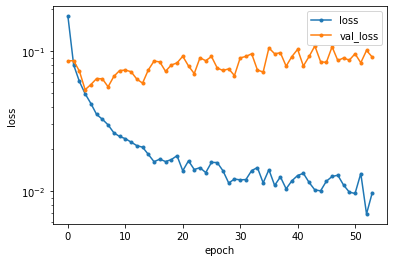

Confusion matrix, without normalization
[[18070    20    24     2     2]
 [  152   395     9     0     0]
 [   68     6  1353    17     4]
 [   40     0    13   109     0]
 [   60     0     6     0  1542]]


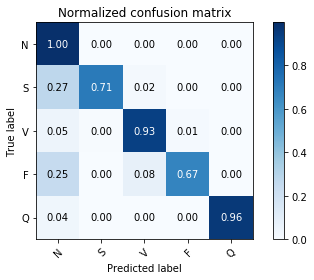

In [3]:
print(
    "Train accuracy:",
    model_res.evaluate(inputs["train"], labels["train"], verbose=0)[1],
)
print(
    "Test accuracy:",
    model_res.evaluate(inputs["test"], labels["test"], verbose=0)[1],
)
plot.plot_fit_history(history)

test_pred = np.argmax(model_res.predict(inputs["test"]), axis=1)
plot.plot_cm(sparse_labels["test"], test_pred, classes=np.array(["N", "S", "V", "F", "Q"]), normalize=True)

Let's save the model with it's architecture and weights.

In [4]:
if not os.path.exists(os.path.join("..", "models", rightnow, "nofft")):
    os.makedirs(os.path.join("..", "models", rightnow, "nofft"))
model_res.save(os.path.join("..", "models", rightnow, "nofft", "wavenet.h5"))

model_res.summary()

Model: "conv1d"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 187, 94)      188         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 187, 94)      17766       conv1d[0][0]                     
_____________________________________________________________________________________________